<a href="https://colab.research.google.com/github/Kerriea-star/Tensorflow-with-Sructured-Data/blob/main/TensorFlow_with_Tabular_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

How to classify structured data, such as tabular data, using a simplified version of the PetFinder dataset from a Kaggle competition stored in a CSV file.

We will use Keras to define the model, the Keras preprocessing layers as a bridge to map from columns in a CSV file to features used to train the model. The goal is to predict if a pet will be adopted.

This tutorial contains complete code for:


*   Loading a CSV file into a DataFrame using pandas
*   Building an input pipline to batch and shuffle the rows using tf.data.
*   Mapping from columns in the CSV file to features used to train the model with the Keras preprocessing layers.
*   Building, training, and evaluating a model using the Keras built-in methods.



In [1]:
# imports
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers

In [2]:
tf.__version__

'2.12.0'

**Load the dataset and read it into a pandas DataFrame**

Use tf.keras.utils.get_file to download and extract the CSV file with the PetFinder.my mini dataset, and load it into a DataFrame with pandas.read_csv

In [3]:
dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
csv_file = 'datasets/petfinder-mini/petfinder-mini.csv'

tf.keras.utils.get_file("petfinder_mini.zip", dataset_url, extract=True, cache_dir='.')
dataframe = pd.read_csv(csv_file)

1668792/1668792 [==============================] - 0s 0us/step


In [4]:
# Inspect the dataframe
dataframe.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2


**Create a target variable**

The original task in Kaggle's PetFinder.my Adoption Prediction competition was to predict the speed at which a pet will be adopted(e.g. in the first week, the first month, the first three months, and so on).

In this tutorial, you will simplify the task by transforming it into a binary classification problem, where you simply have to predict whether a pet was adopted or not.

After modifying the AdoptionSpedd column, 0 will indicate the pet was not adopted and 1 will indicate it was

In [5]:
# In the original dataset, `'AdoptionSpeed'` of `4` indicated
# a pet was not adopted.
dataframe["target"] = np.where(dataframe["AdoptionSpeed"]==4, 0, 1)

# Drop unused features
dataframe = dataframe.drop(columns=["AdoptionSpeed", "Description"])

**Split the DataFrame into training, validation and test sets**

The dataset is in a single pandas DataFrame. Split it into training,validation and test sets using a, for example ratio, 80:10:10 ratio, respectively:

In [6]:
train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])


In [7]:
print(len(train), "training examples")
print(len(val), "validation examples")
print(len(test), "test examples")

9229 training examples
1154 validation examples
1154 test examples


**Create an input pipeline using tf.data**

Next create a utility function that coverts each training, validation, and test set DataFrame into a tf.data.Dataset, the shuffles and batches the data

In [8]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop("target")
  df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

Now, use the newly created function (df_to_dataset) to check the format of the data the input pipeline helper function returns by calling it on the training data, and use a small batch size to keep the output readable

In [9]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

<ipython-input-8-afd0e8d47bf3>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}


In [10]:
[(train_features, label_batch)] = train_ds.take(1)
print("Every feature:", list(train_features.keys()))
print("A batch of ages:", train_features["Age"])
print("A batch of targets:", label_batch)

Every feature: ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt', 'target']
A batch of ages: tf.Tensor(
[[1]
 [6]
 [3]
 [3]
 [4]], shape=(5, 1), dtype=int64)
A batch of targets: tf.Tensor([1 1 0 1 1], shape=(5,), dtype=int64)


As the output demonstrates, the training set returns a dictionary of column names (from the DataFrame) that map to column values from rows.

**Apply the Keras preprocessing layers**

The Keras preprocessing layers allow you to build Keras-native input processing pipelines, which can be used as independent preprocessing code in non-Keras workflows, combined directly with Keras models and exported as part of Keras SavedModel.

We will use the following four preprocessing layers to demonstrate how to perform preprocessing, structured data encoding and feature engineering.

*   tf.keras.layers.Normalization: Performs feature-wise normalization of input features.
*   tf.keras.layers.CategoryEncoding: Turns integer categorical features into one-hot, multi-hot or tf-idf dense representations.
*   tf.keras.layers.StringLookup: Turns sttring categorical values into integer indices
*   tf.keras.layers.IntegerLookup: Turns integer categoriccal values into integer indices.

*   For numerical features of the PetFinder.my mini dataset, you will use a tf.keras.layers.Normalization layer to standardize the distribution of the data
*   For categorical features such as pet Type s(Dog and Cat strings), you will transform them to mutli-hot encoded tensors with tf.keras.layers.CategoryEncoding.





**Numerical columns**

For each numeric feature in the PetFinder.my mini dataset, you will use a tf.keras.layers.Normalization to standardize the distribution of the data.

Define a new utility function that returns a layer which applies feature-wise normalization to numerical features using that Keras preprocessing layer:

In [11]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [12]:
# test the new function by calling it on the total uploaded pet photo features to
# normalize "PhotoAmt"
photo_count_col = train_features["PhotoAmt"]
layer = get_normalization_layer("PhotoAmt", train_ds)
layer(photo_count_col)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 0.44240412],
       [-0.823922  ],
       [-0.19075891],
       [-0.50734043],
       [-0.50734043]], dtype=float32)>

**Note:** If you have many numeric features (hundreds or more), it is more efficient to concatenate them first and use a single tf.keras.layers.Normalization layer

**Categorical columns**
Pet Types in the dataset are represented as strings Dogs, and Cats which need to be mutli-hot encoded before being fed into the model.

Define another new utility function that returns a layer which maps values from a vocabulary to integer indices and mutli-hote encodes the feature using the tf.keras.layers.StringLookup, tf.keras.layers.IntegerLookup and tf.keras.layers.CategoryEncoding preprocessing layers:

In [13]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices
  if dtype == "string":
    index = layers.StringLookup(max_tokens=max_tokens)
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a 'tf.data.Dataset' that only yields the feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index
  index.adapt(feature_ds)

  # Encode the integer indices
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Function model later
  return lambda feature: encoder(index(feature))

In [14]:
# Test the get_category_encoding_layer function by calling it on pet Type
# features to turn them into multi-hot encoded tensors:
test_type_col = train_features["Type"]
test_type_layer = get_category_encoding_layer(name="Type",
                                              dataset=train_ds,
                                              dtype="string")
test_type_layer(test_type_col)

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)>

In [15]:
# Repeat the process on "Age" features
test_age_col = train_features["Age"]
test_age_layer = get_category_encoding_layer(name="Age",
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
test_age_layer(test_age_col)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)>

**Preprocess selected features to train the model on**

We have learned how to use several types of Keras preprocessing layers. Next, we will:

*   Apply the preprocessing utility functions defined earlier on 13 numerical and categorical features from the PetFinder.my mini dataset
*   Add all the feature inputs to a list

Earlier, we used a small batch size to demonstrate the input pipeline. Let's now create a new input pipeline with a larger batch size of 256




In [16]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

<ipython-input-8-afd0e8d47bf3>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}
<ipython-input-8-afd0e8d47bf3>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}
<ipython-input-8-afd0e8d47bf3>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}


Normalize the numerical features(the number of pet photos and the adoption fee), and add them to one list of inputs called encoded_features:

In [17]:
all_inputs = []
encoded_features = []

# Numerical features:
for header in ["PhotoAmt", "Fee"]:
  numeric_col = tf.keras.Input(shape=(1, ), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

Turn the integer categorical values from the dataset (the pet age) into integers indices, perform multi-hot encoding, and add the resulting feature inputs to encoded_features:

In [18]:
age_col = tf.keras.Input(shape=(1,), name="Age", dtype="int64")

encoding_layer = get_category_encoding_layer(name="Age",
                                             dataset=train_ds,
                                             dtype="int64",
                                             max_tokens=5)

encoded_age_col = encoding_layer(age_col)
all_inputs.append(age_col)
encoded_features.append(encoded_age_col)

In [19]:
# Repeat the same step for the string categorical values
categorical_cols = ["Type", "Color1", "Color2", "Gender", "MaturitySize",
                    "FurLength", "Vaccinated", "Sterilized", "Health", "Breed1"]

for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype="string")
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype="string",
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

**Create, compile and train the model**

The next step is to create a model using Keras Functional API. For the first layer in your model, merge the list of feature inputs -encoded_features into one vector via concatenation with tf.keras.layers.concatenate

In [20]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

In [21]:
# Configure the model with Keras Model.Compile:
model.compile(optimizer="adam",
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

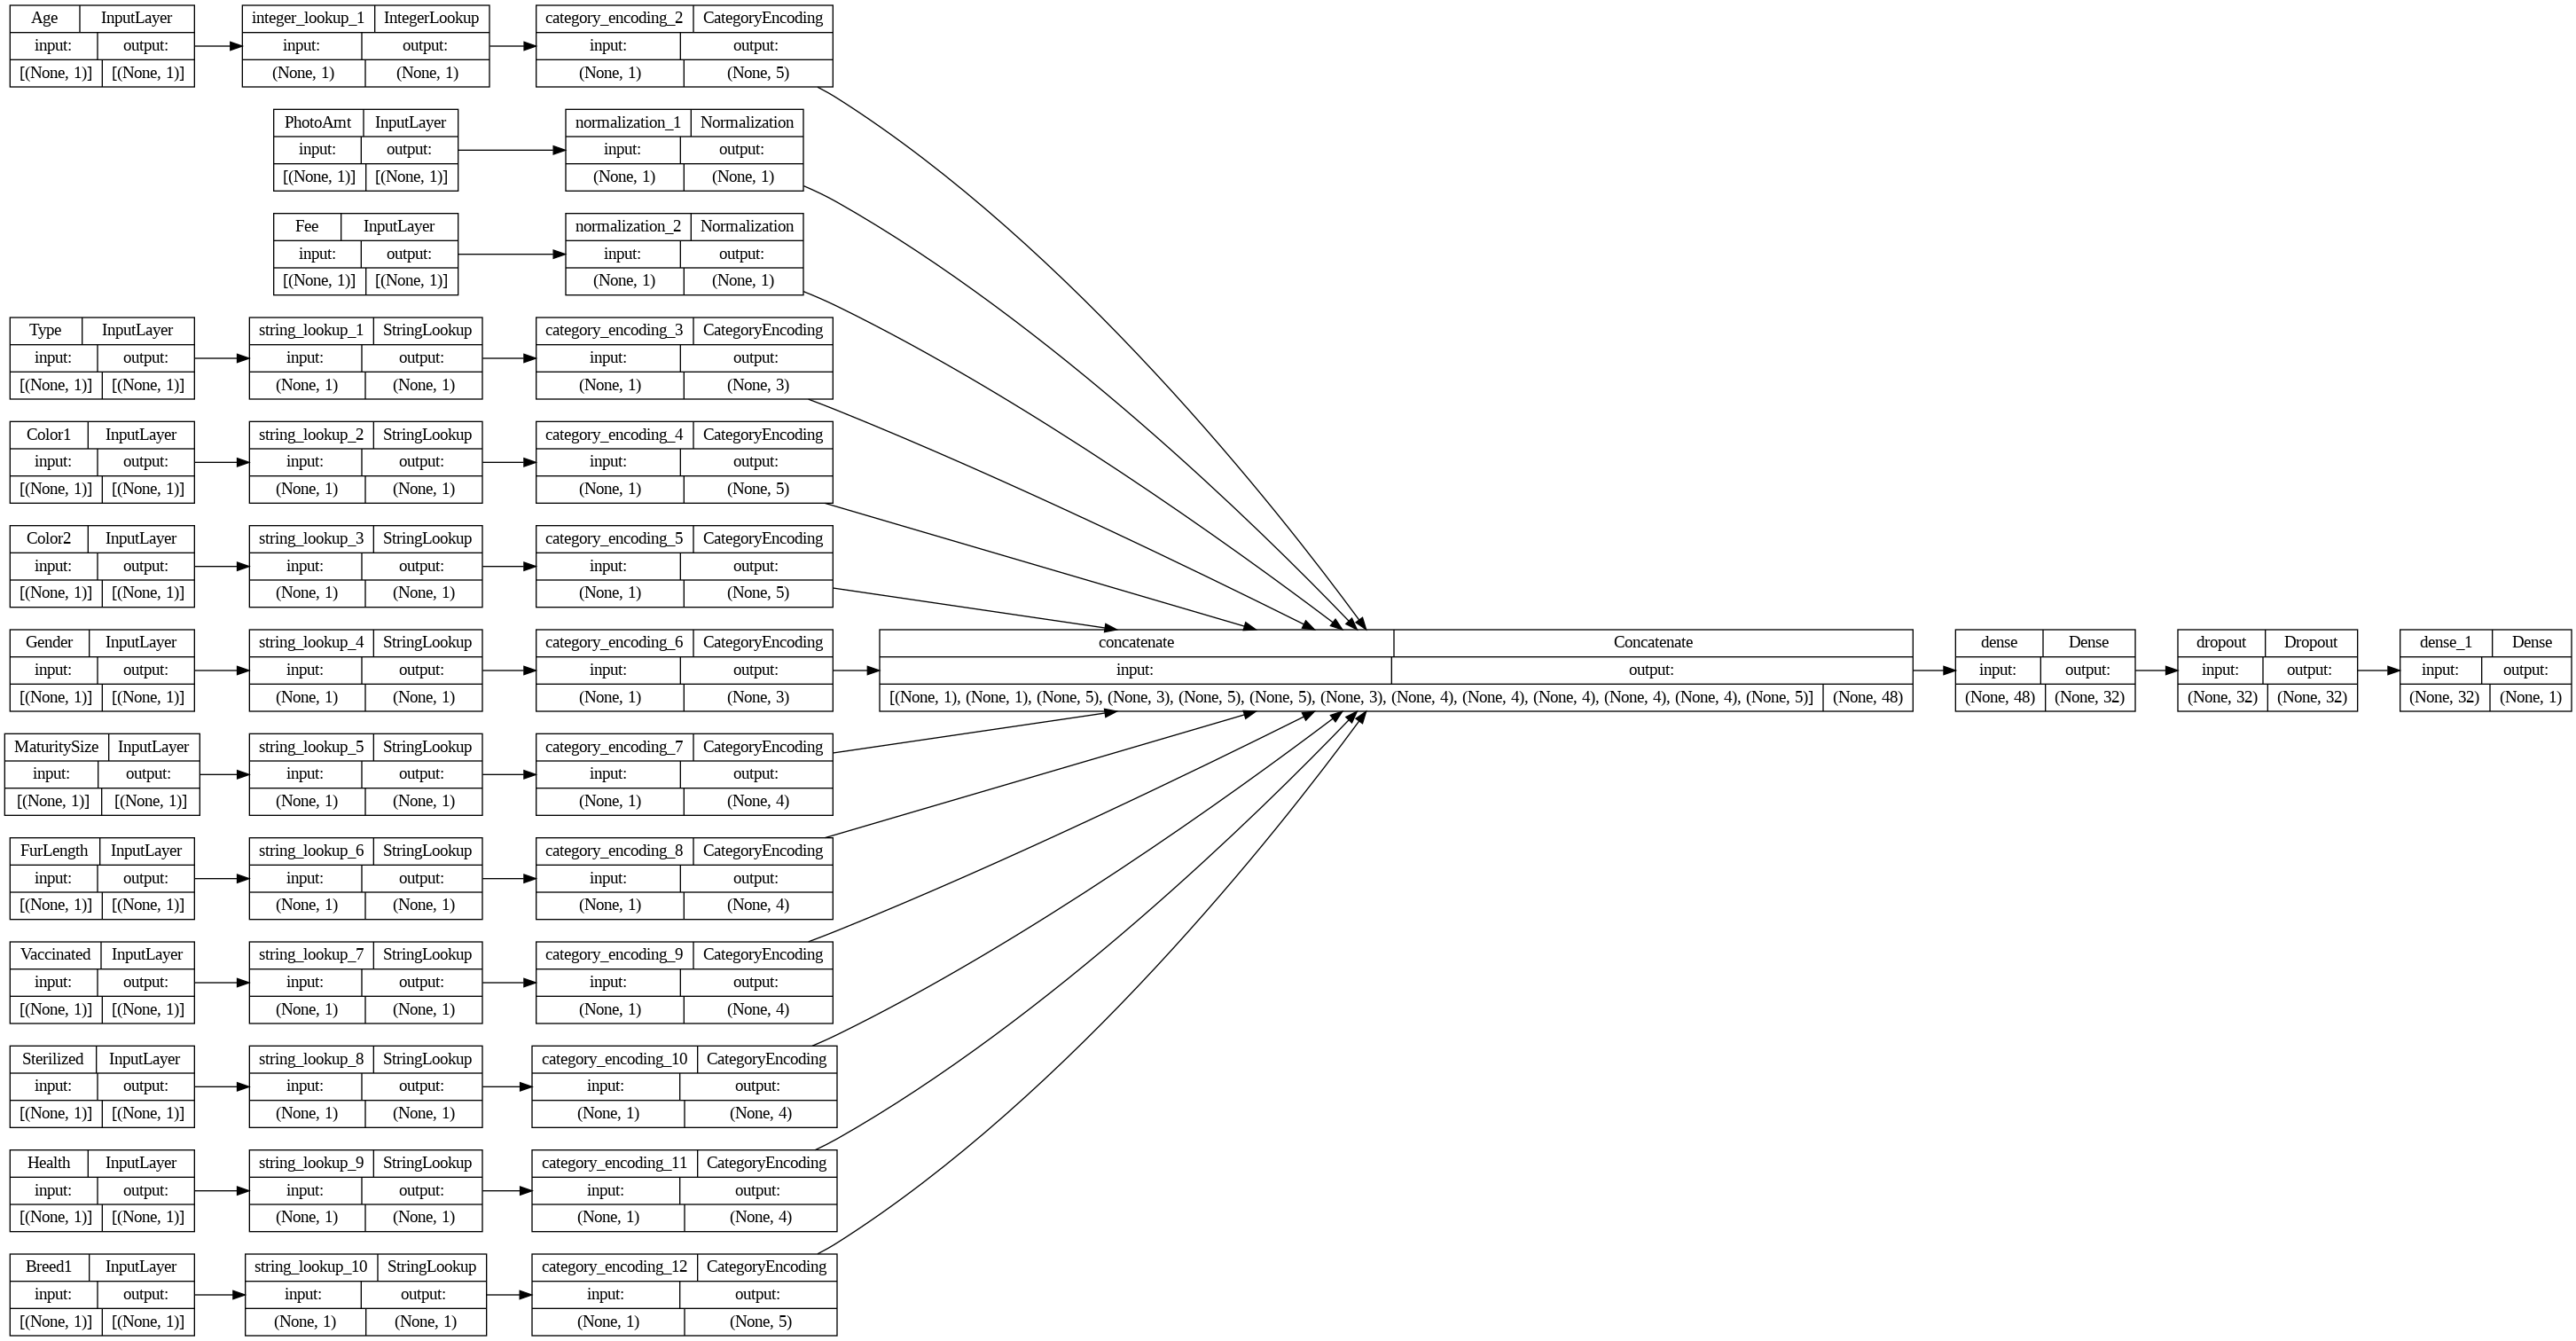

In [23]:
# Let's visualize the connectivity graph:
# Use "rankdir=LR" to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")